## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_style('white')
sns.set_context('talk')

In [3]:
## db connection
from psql_etl import establish_connection
db_con = establish_connection()

In [4]:
customers = pd.read_sql('SELECT * FROM customers;', db_con)

In [5]:
customers.columns

Index(['id', 'signup_date', 'loyalty', 'location', 'gender', 'age',
       'favorite_movie_line', 'number_of_purchases', 'value_of_purchases',
       'total_standard_points', 'total_points_redeemed'],
      dtype='object')

## Topline Differences between test and control groups
- Average spent amount
- Total Purchases

In [6]:
customers.groupby('loyalty').mean()[['number_of_purchases', 'value_of_purchases']]

,number_of_purchases,value_of_purchases
loyalty,,
control,8.717783,24021.662495
enrolled,11.697732,35708.542570


In [7]:
(
    customers.groupby('loyalty').mean()[['number_of_purchases', 'value_of_purchases', 'total_points_redeemed']]
    .apply(lambda x: (x['value_of_purchases'] - x['total_points_redeemed']/10) / x['number_of_purchases'], axis=1)
)

loyalty
control     2755.478379
enrolled    3034.821113
dtype: float64

In [8]:
## proportion who did not purchase at all
(
    customers.groupby('loyalty').count()[['number_of_purchases', 'id']]
    .apply(lambda x: x['number_of_purchases'] / x['id'], axis=1)
)

loyalty
control     0.726737
enrolled    0.807304
dtype: float64

In [9]:
## statistical significance for those who made at least one purchase
from scipy.stats import ttest_ind
def perform_ttest(df, metric):
    p_value = ttest_ind(
        df.loc[(df['number_of_purchases'].notnull()) & 
                      (df['number_of_purchases']>0) &
                      (df['loyalty']=='enrolled'), metric],
        df.loc[(df['number_of_purchases'].notnull()) & 
                      (df['number_of_purchases']>0) &
                      (df['loyalty']=='control'), metric],
    )[1]
    return '{} {}, with p-value {}'.format(metric, 'significant' if p_value<0.05 else 'NOT significant', p_value)

for metric in ['number_of_purchases', 'value_of_purchases']:
    print(perform_ttest(customers, metric))

number_of_purchases significant, with p-value 1.2038609614415836e-23
value_of_purchases significant, with p-value 8.818505942971227e-21


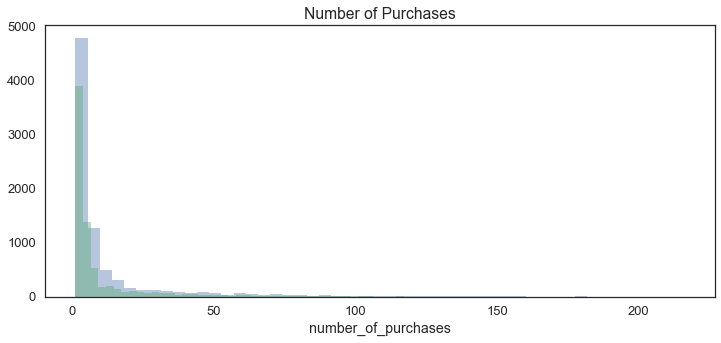

In [10]:
_ = plt.subplots(1,1, figsize=(12,5))
ax = plt.gca()
ax.set_title('Number of Purchases')
for status in ['enrolled', 'control']:
    sns.distplot(
        customers.loc[(customers['loyalty']==status) & (customers['number_of_purchases'].notnull()), 
                      'number_of_purchases'], kde=False, ax=ax
    )

In [11]:
## Revenue Loss from Program
c2 = customers.copy()
c2['revenue_loss'] = c2['total_points_redeemed'].fillna(0) / 10
c2[c2['loyalty']=='enrolled'].mean()['revenue_loss']

167.93396698349176

In [12]:
c2['total_points_redeemed'].sum()/10

1678500.0

## Retention Trends

In [13]:
sql = """
    SELECT t.*, c.loyalty
    FROM transactions_derived t
    INNER JOIN customers c 
    ON t.user_id = c.id
    ;
"""
transactions = pd.read_sql(sql, db_con)

In [14]:
transactions.columns

Index(['date', 'user_id', 'value', 'point_differential', 'standard_points',
       'number_of_redemptions', 'transaction_order', 'transaction_recency',
       'loyalty'],
      dtype='object')

In [15]:
first_purchases = transactions[transactions['transaction_order']==1]
second_purchases = transactions[transactions['transaction_order']==2]
user_retention = pd.merge(
    first_purchases[['date', 'user_id', 'value', 'loyalty']],
    second_purchases[['date', 'user_id', 'value']],
    how='left',
    on='user_id'
)

In [16]:
user_retention.head()

,date_x,user_id,value_x,loyalty,date_y,value_y
0,2013-02-12,1,4121,enrolled,2013-04-26,4515.0
1,2012-01-29,2,2524,enrolled,2012-04-18,1739.0
2,2012-04-06,3,0,control,2012-05-02,1084.0
3,2012-04-14,4,2509,enrolled,2012-04-30,2525.0
4,2012-01-20,5,2810,enrolled,2012-01-30,1762.0


In [17]:
user_retention.columns = ['date1', 'user_id', 'value1', 'loyalty', 'date2', 'value2']

In [18]:
user_retention['date_differential'] = (user_retention['date2'] - user_retention['date1']).dt.days

In [19]:
## days between first and second purchase
user_retention.groupby('loyalty').mean()['date_differential']

loyalty
control     78.758979
enrolled    68.250872
Name: date_differential, dtype: float64

In [20]:
## retention rates
user_retention.groupby('loyalty').count()[['value1', 'value2']].apply(lambda x: x['value2']/x['value1'], axis=1)

loyalty
control     0.754367
enrolled    0.817078
dtype: float64

In [21]:
user_retention.count()[['value1', 'value2']]

value1    15340
value2    12078
dtype: int64

In [22]:
c2['frequency'] = c2['number_of_purchases'].apply(lambda x: 100 if x>=100 else x)

In [23]:
retained_users = (
    c2.groupby('frequency').count()['id']
    .iloc[::-1].cumsum().iloc[::-1].shift(periods=1).reset_index()
)
drop_off_rates = pd.merge(
    retained_users,
    c2.groupby('frequency').count()['id'].reset_index(),
    on='frequency',
    how='inner'
)

In [24]:
drop_off_rates.columns = ['frequency', 'beginning_user_count', 'users_dropped']
drop_off_rates['drop_off_rate'] = drop_off_rates.apply(lambda x: x['users_dropped'] / x['beginning_user_count'], axis=1)

In [25]:
drop_off_rates.head()

,frequency,beginning_user_count,users_dropped,drop_off_rate
0,1.0,NaN,3262,NaN
1,2.0,15340.0,2334,0.152151
2,3.0,12078.0,1812,0.150025
3,4.0,9744.0,1328,0.136289
4,5.0,7932.0,995,0.125441


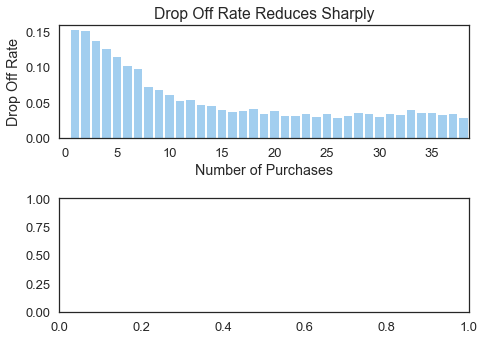

In [26]:
_ = plt.subplots(2,1,figsize=(7,5))

ax = plt.subplot(2,1,1)
sns.barplot(
    x='frequency', y='drop_off_rate', data=drop_off_rates[drop_off_rates['frequency'].isin(np.arange(1,40,1))], 
    ax=ax, color='xkcd:light blue')
ax.set_title('Drop Off Rate Reduces Sharply')
ax.set_ylabel('Drop Off Rate')
ax.set_xlabel('Number of Purchases')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# ax = plt.subplot(2,1,2)
# sns.barplot(x='frequency', y='beginning_user_count', data=drop_off_rates[drop_off_rates['frequency'].isin(np.arange(1,30,1))], ax=ax, color='xkcd:light red')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.set_title('Users Remaining')
# ax.set_ylabel('Users Remaining')
# ax.set_xlabel('Number of Purchases')

plt.tight_layout()


## Users who did not use points

In [27]:
c2.loc[(c2['loyalty']=='enrolled') & (c2['total_standard_points']>=5000), 'redemption_opp'] = 1

In [28]:
c2['redemption_opp'] = c2['redemption_opp'].fillna(0)

In [29]:
c2[c2['loyalty']=='enrolled'].groupby('redemption_opp').mean()['value_of_purchases']

redemption_opp
0.0     31466.196522
1.0    169496.399194
Name: value_of_purchases, dtype: float64

In [30]:
c2.loc[(c2['loyalty']=='enrolled') & (c2['total_standard_points']>=5000), 'value_of_purchases'].mean()

169496.39919354839

In [31]:
c2.loc[(c2['loyalty']=='enrolled') & (c2['total_points_redeemed']>0), 'value_of_purchases'].mean()

194568.55630413859

In [32]:
redemption_opp = transactions.loc[transactions['standard_points']>=5000, 'user_id'].unique()

In [33]:
c2.loc[(c2['id'].isin(redemption_opp)), 'total_points_redeemed'].value_counts().apply(lambda x: x / redemption_opp.shape[0])

5000.0      0.391753
10000.0     0.163230
0.0         0.107388
15000.0     0.091065
20000.0     0.067010
25000.0     0.041237
30000.0     0.028351
35000.0     0.018900
45000.0     0.018041
55000.0     0.012027
40000.0     0.011168
50000.0     0.008591
60000.0     0.007732
65000.0     0.006873
70000.0     0.006014
100000.0    0.003436
75000.0     0.003436
80000.0     0.003436
85000.0     0.002577
90000.0     0.002577
95000.0     0.001718
120000.0    0.000859
105000.0    0.000859
140000.0    0.000859
110000.0    0.000859
Name: total_points_redeemed, dtype: float64

In [35]:
customers['number_of_purchases'].notnull().sum()

15340

In [36]:
customers['loyalty'].value_counts()

control     10005
enrolled     9995
Name: loyalty, dtype: int64